# 2018-10-16 Multi-filtres
Mini notebook pour faire plusieurs filtres à la fois, histoire de bien vérifier que ça marche

### 18/10 Ca marche mais c'est pas a jour avec les modifs de Laurent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

def find_middle(a_list):
    middle = len(a_list)/2
    return a_list[int(middle)]

# Filtres spatial, temporel, spatiotemporel, conversion en spikes

In [2]:
#Un premier filtre, spatial avec center-surround (voir et citer MARR ?)
def spatial_filter(wx = 5., wy = 5., xres = .1, yres = .1, sigma_center = 1., sigma_surround= 1.2,
                  x_trans = 0, y_trans = 0, theta = 0, end_multiplier = -.01) :
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    theta = 0 : rotates the whole filter '''
    
    theta = theta*np.pi/180 #je vais finir par appeller ça la conversion perrinet 

    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    X_ = np.cos(theta) * X + np.sin(theta) * Y
    Y = -np.sin(theta) * X + np.cos(theta) * Y
    X = X_

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (17.0 / sigma_center**2) * np.exp(-(radius / sigma_center)**2)
    surround = (16.0 / sigma_surround**2) * np.exp(-(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X,Y,Z

In [3]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0.001):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    k = int(t//(response_time+refrac_time)) #get the signal period we're currently in
    #reset the filter if the refraction is over
    if t > (response_time+refrac_time)*k :
        t = t - (response_time+refrac_time)*k
    
    #t = np.arange(0, total_time*t_res, t_res)
    p1 = baseline+K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p2 = K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return (p1-p2)*90 #oups je me suis planté d'un facteur 90, c'est un sacré miss

def activation_temporal_filter(X,Y,Z,t,filtertime, 
                            activation_threshold, refractory_period,
                            stim, stimtime,baseline = .001, verbose = False):
    '''
    An activation-based temporal filter, that only starts after the associated spatial filter as detected
    something above the activation_threshold. It is used to convert a regular temporal filterinto a more 
    realist one, in the sense it works like an adaptative response and not an oscillator
    Args :
    --> X,Y,Z = Spatial filter
    --> t, filtertime, baseline = Temporal filter and associated total time, as well as the baseline
    --> activation_threshold = Threshod above which the spatial filter is activated
    --> refractory_period = Period during which the modified temporal filter becomes inactive
    --> stim, stimtime = Stimulus and associated stimulus total time, usually equals to the filtertime
    '''
    
    v2_filter = []
    deactivation_delay = 0
    for i in np.linspace(0,filtertime, filtertime) :
        activation = np.max(Z*stim[int(i)])
    
        if deactivation_delay == 0 :
            if activation < activation_threshold : #the spatial hasn't seen anything
                v2_filter.append(baseline*90) #don't forget the 90 corrective factor
            else : #we start a new countdown
                deactivation_delay = refractory_period
                if verbose :print('The spatial filter started detecting something at %s ms' % int(i))
        else : #we're doing a reponse
            deactivation_delay -=1
            v2_filter.append(temporal_filter(refractory_period-deactivation_delay))
            
    return v2_filter

In [4]:
def spatiotemporal_filter(spatio_X, spatio_Y, spatio_Z, tempo):
    '''
    Returns a 4D spatiotemporal filter, structure as : of tempo length with each element being X/Y/Z,
    each X/Y/Z having the samedimensions as that of the given spatial filter. 
    Temporal resolution is the same as the temporal filter
    --> spatio_X, Y, Z : spatial filter
    --> tempo = temporal filter
    '''
    st_filter = [] #bizarrement c'est plus rapide qu'une array
    for i, temporal_function in enumerate(tempo):
        st_filter.append(Z*temporal_function)
    
    return st_filter

In [5]:
def filter_to_spikes(activated_filter, exponential_size, random_seed):
    '''
    Converts an activated spatiotemporal filter (that is, convolved around a stimuli) into a series of 
    spike trains using Dayan-Abbott (2001) thinning
    Args :
    --> activated_filter = a spatiotemporal filter convolved around a stimuli
    --> exponential_size = the beta of the exponential distribution. Since we normalize it by the maximum
    activation of the filter's rate, the lower it is the more spike the conversion will produce (20 is nice)
    --> random_seed = fixes numpy's seed for reproducibility
    '''
    
    #activated_filter = np.asarray(activated_filter)
    np.random.seed(random_seed)
    activated_filter = np.asarray(activated_filter)
    r_max = np.max(activated_filter)

    explaw = np.random.exponential(exponential_size/ r_max, size = len(activated_filter))
    spike_times = np.cumsum(explaw)
    

    remove_end = spike_times < 795
    remove_beg = spike_times > 10
    spike_times = spike_times[remove_end*remove_beg]

    spike_indexes = np.floor(spike_times).astype(int)
    x = np.random.rand(spike_indexes.size)

    ratio = activated_filter[spike_indexes]/r_max
    spike_times = spike_times[ratio >= x]
    
    return spike_times

# Subsampling a stimulus

In [31]:
#We generate the regular moving japanese flag
total_time = 800

jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        jap_flags.append(japanese_flag)
        
#and we only keep what's around in a filter radius
filter_coordinates = [50,50] #that's the center of the image, so we should except to see something at t 400
filter_size = 5. #wx and wy of the filters

ims_shown = []
for stimuli in jap_flags :
    im_shown = stimuli[int(filter_coordinates[0]-filter_size):int(filter_coordinates[0]+filter_size),
                   int(filter_coordinates[1]-filter_size):int(filter_coordinates[1]+filter_size)]
    ims_shown.append(im_shown)

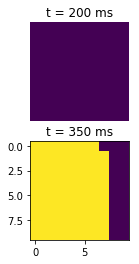

In [32]:
fig, axs = plt.subplots(nrows = 2)
axs[0].imshow(ims_shown[200])
axs[0].set_axis_off()
axs[0].set_title('t = 200 ms')
axs[1].set_title('t = 350 ms')
axs[1].imshow(ims_shown[350])

# Subsampling with 3 filters

In [83]:
from mpl_toolkits.mplot3d import Axes3D
############
# Constants
############
baseline = 0.001
total_time = 800
filter_size = 5.
n = 10

nbr_filters = 3
filters_coordinates = [ [50,40], [50,50], [50,60] ]

sub_imgs = [] #here we subsample the images
for i, fts in enumerate(filters_coordinates):
    ims_shown = []
    for stimuli in jap_flags :
        im_shown = stimuli[int(filters_coordinates[i][0]-filter_size):int(filters_coordinates[i][0]+filter_size),
                       int(filters_coordinates[i][1]-filter_size):int(filters_coordinates[i][1]+filter_size)]
        ims_shown.append(np.kron(im_shown, np.ones((n,n)))) #the kron product upscales the matrix
    sub_imgs.append(ims_shown)

Filter on X from 45.0 to 54.90000000000014
Filter on Y from 35.0 to 44.90000000000014
Image size is (100, 100)
Subimage size is (100, 100) 

Filter on X from 45.0 to 54.90000000000014
Filter on Y from 45.0 to 54.90000000000014
Image size is (100, 100)
Subimage size is (100, 100) 

Filter on X from 45.0 to 54.90000000000014
Filter on Y from 55.0 to 64.90000000000015
Image size is (100, 100)
Subimage size is (100, 100) 



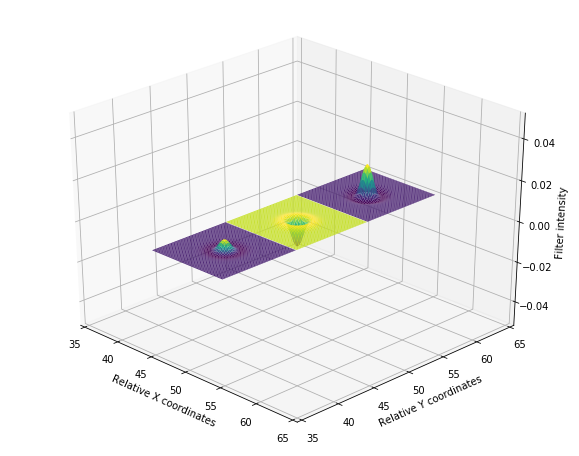

In [96]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(azim = -45, elev=30)
ax.set_xlim(35,65)
ax.set_ylim(35,65)
ax.set_zlim(-.05,.05)

########
# STIM
########
jap_flags = []
for i in range(total_time+1):
        xx, yy = np.mgrid[:100, :100]
        circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
        japanese_flag = (circle < 100)
        jap_flags.append(japanese_flag)

###########
# Multiple filters 
###########
spiketimes_list = []
activations_list = []
for filt in range(nbr_filters) :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    
    print('Filter on X from %s to %s' % (np.min(X), np.max(X)))
    print('Filter on Y from %s to %s' % (np.min(Y), np.max(Y)))
    print('Image size is %s' % str(jap_flags[0].shape))
    print('Subimage size is %s \n' % str(sub_imgs[filt][0].shape))
    ax.set_zlabel('Filter intensity')
    ax.set_xlabel('Relative X coordinates') 
    ax.set_ylabel('Relative Y coordinates')
    
    temporal = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    activation_temporal = activation_temporal_filter(X=X,Y=Y,Z=Z, baseline=baseline,
                                                 t = temporal, filtertime = total_time,
                                                 activation_threshold = .001, refractory_period = 225,
                                                 stim = sub_imgs[filt], stimtime = total_time)
    st_filter = spatiotemporal_filter(spatio_X = X, spatio_Y = Y, spatio_Z = Z,
                                       tempo = activation_temporal)
    ax.plot_surface(X,Y,st_filter[400], cmap = plt.cm.viridis)
    
    ############
    # Activation
    ############
    st_activations= []
    for i, st_response_new in enumerate(st_filter):
        #st_activations.append(scipy.signal.convolve2d(st_response_new * sub_imgs[filt][int(i)]))
        st_activations.append(np.sum(st_response_new * sub_imgs[filt][int(i)]))
    activations_list.append(st_activations)

    ############
    # Conversion
    ############
    spiketimes = filter_to_spikes(st_activations, 20, random_seed = 42)
    spiketimes_list.append(spiketimes)

In [97]:
spiketimes_list

[array([253.1902711 , 254.01103468, 254.03154982, 260.29231189,
        269.67572545, 275.14112859, 275.42613761]),
 array([331.04997897, 333.57227448, 336.31265086, 338.37925161,
        338.47464246, 339.01592068, 342.76419577, 344.16238236,
        346.79442367, 355.61658199, 445.21648576, 473.7580478 ]),
 array([409.36519887, 426.7285412 , 511.53721902])]

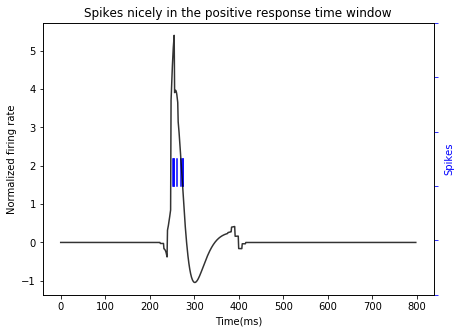

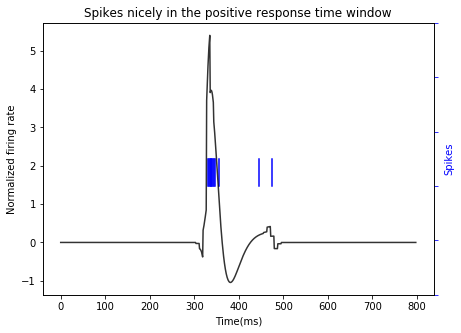

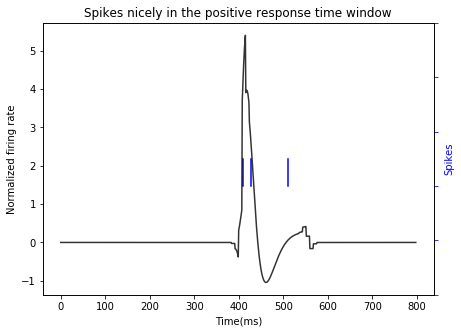

In [103]:
for output in range(len(activations_list)):
    fig, ax = plt.subplots(figsize = (7,5))

    for i, spike in enumerate(spiketimes_list[output]) :
        ax.axvline(spike, ymin = .4, ymax = .5, color = 'b')

    ax.plot(activations_list[output], label = 'Activation-based Spatiotemporal filter', color = 'k', alpha = .8)


    ax.tick_params(colors = 'k')
    ax.set_ylabel('Normalized firing rate', color = 'k')
    ax.set_xlabel('Time(ms)')

    ax2 = ax.twinx()
    ax2.tick_params(colors = 'b')
    ax2.set_ylabel('Spikes', color = 'b')
    ax2.set_yticklabels([])

    plt.title('Spikes nicely in the positive response time window')
    plt.show()
    

# Animation du rond qui bouge

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn

%matplotlib notebook
fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(800):
    xx, yy = np.mgrid[:100, :100]
    circle = (xx - 50) ** 2 + (yy - int(i/8)) ** 2
    japanese_flag = (circle < 500)
    im = plt.imshow(japanese_flag, animated=True, cmap = plt.cm.binary)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 10,
                                 repeat = True)
plt.show()

% matplotlib notebook

# Ca c'est super expérimental et ça a sérieusement de quoi faire fondre le CPU, a toucher avec prudence !
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

fig = plt.figure()
ax = p3.Axes3D(fig)

maxtime = 224
X,Y,Z = spatial_filter()
ys = [temporal_filter(i) for i in np.linspace(0,maxtime,maxtime)]

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(maxtime):
    im = ax.plot_surface(X,Y, ys[i]*Z, cmap = plt.cm.viridis, vmin = -.02, vmax = .05,)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval = 10,
                                 repeat = True, blit = False)
ani.save('matplot002.gif', writer='imagemagick', dpi = 200)
plt.show()